### ファイル名入力

In [115]:
file = "filtered_bestplan.csv"
#file = "automation_med_best_result/re_best_results_median_data_r100_t500_λ_review.csv"

### ライブラリのインポート

In [116]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import math
import re
import ast
import matplotlib.pyplot as plt
# 日本語フォントを使用する
plt.rcParams['font.family'] = 'IPAexGothic'

attractions = {
    0: 'ソアリン',
    1: 'トイストーリーマニア',
    2: 'タワーオブテラー',
    3: 'センターオブジアース',
    4: 'インディージョーンズ',
    5: 'レイジングスピリッツ',
    6: 'マジックランプシアター',
    7: 'タートルトーク'
}

### 表示に必要な関数を定義

In [117]:
# 分を24時間表示に変換
def calculate_time(minutes):
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    total_minutes = start_time + minutes
    
    # 時間と分に変換
    hours = total_minutes // 60
    mins = total_minutes % 60
    
    # 24時間表記に変換
    if hours >= 24:
        hours -= 24
    
    # 時間と分を文字列に変換して返す
    return f"{hours:02d}:{mins:02d}"

In [118]:
# 24時間表示を分に変換
def calculate_minutes(time_str):
    # 時刻を時間と分に分割
    hours, mins = map(int, time_str.split(":"))
    
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    # 入力された時刻を分単位に変換
    total_minutes = hours * 60 + mins
    
    # 24時間以上の場合は調整
    if total_minutes < start_time:
        total_minutes += 24 * 60
    
    # 開始時刻からの経過時間を計算
    elapsed_minutes = total_minutes - start_time
    
    return elapsed_minutes

In [119]:
def not_in_new_ride(a, b):
    ans=a
    # リストaからリストbに含まれている要素を取り除く
    for item in b:
        if item in a:
            ans.remove(item)
    return ans

In [120]:
def ride_printer(date, total_popularity, total_time, ride_lst, new_ride_lst, ride_time):
    print("-" * 40)
    print(f"~ {date} のデータによる乗車プラン ~")
    print("乗車時間　：　アトラクション名")
    for i in range(len(new_ride_lst)):
        print(f"{calculate_time(ride_time[i])}　： {attractions.get(new_ride_lst[i])}")
    print('トータル所要時間：',total_time)
    print('トータル満足度　：',total_popularity)
    print("-" * 40)
    if not(len(ride_lst)==len(new_ride_lst)):
        print("※全てのアトラクションを乗ることができません")
        print("プランから除外されたアトラクション")
        not_ride = not_in_new_ride(ride_lst, new_ride_lst)
        for i in not_ride:
            print(f"{i}　： {attractions.get(i)}")

### プランの可視化

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

def plot_time_schedule(df_data, num_samples=10):
    # CSVファイルからデータを読み込む
    df = df_data

    # 最初の num_samples 個のデータのみを抽出
    df_sample = df.head(num_samples)

    # "最適プラン" と "タイムスケジュール" colのデータを取得
    optimal_plans_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in df_sample["最適プラン"]]
    time_schedule_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in df_sample["タイムスケジュール"]]

    # カラーマップを定義
    num_colors = len(optimal_plans_list)
    colors = plt.cm.get_cmap('tab10', num_colors)

    # プロットの準備
    plt.figure(figsize=(18, 10))  # グラフのサイズを広く設定

    # optimal_plans_list と time_schedule_list のデータをプロット
    for i in range(len(optimal_plans_list)):
        plt.plot(time_schedule_list[i], optimal_plans_list[i], marker='o', linestyle='-', 
                 label=f'Data {i+1}', color=colors(i))

    # グラフの設定
    plt.xlabel('時間軸', fontsize=14)
    plt.ylabel('アトラクションインデックス', fontsize=14)
    plt.title(f'最適プランとタイムスケジュールの折れ線グラフ ({num_samples} samples)', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)

    # x軸の範囲を調整（必要に応じて）
    plt.xlim(0, 705)  # 例として幅を広く設定

    # y軸の範囲を調整（必要に応じて）
    plt.ylim(0, 7)
    plt.yticks(range(8), [attractions[i] for i in range(8)], fontsize=10)

    # x軸にアトラクションの名称を設定
    x_ticks = range(0, 706, 15)
    x_labels = [f'{calculate_time(tick)}' for tick in x_ticks]
    plt.xticks(x_ticks, x_labels, rotation=45, fontsize=8)
    
    # グラフの表示
    plt.tight_layout()
    plt.show()

### 最適化プランCSVファイルの読み込み

In [122]:
import pandas as pd

# CSVファイルを読み込む
df = pd.read_csv(file)
display(df.head())
display(df.info())
display(df.shape)

# "lambda" 列がある場合、その列を削除
if 'lambda' in df.columns:
    df = df.drop(columns='lambda')

# 最大トータル満足度のデータ
max_popularity = df[df["トータル満足度"] == df["トータル満足度"].max()]

# 最小トータル所要時間のデータ
min_totaltime = df[df["トータル所要時間"] == df["トータル所要時間"].min()]

display(max_popularity)
display(min_totaltime)

# 各要素を取得1
data1 = max_popularity.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
data1 = [data1[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data1[1:]]
date1 = data1[0]
total_popularity1 = data1[1]
total_time1 = data1[2]
ride_lst1 = data1[3]
new_ride_lst1 = data1[4]
ride_time1 = data1[5]

# 各要素を取得2
data2 = min_totaltime.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
data2 = [data2[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data2[1:]]
date2 = data2[0]
total_popularity2 = data2[1]
total_time2 = data2[2]
ride_lst2 = data2[3]
new_ride_lst2 = data2[4]
ride_time2 = data2[5]

# ride_printerで表示
print("トータル満足度が最大のプラン")
ride_printer(data1, total_popularity1, total_time1, ride_lst1, new_ride_lst1, ride_time1)
print()
#print("トータル所要時間が最小のプラン")
#ride_printer(data2, total_popularity2, total_time2, ride_lst2, new_ride_lst2, ride_time2)
#print()

,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
0,median,5649.0,670.5,"[7, 6, 4, 3, 4, 3, 5, 4, 5, 3, 7, 3, 3, 3, 1]","[7, 6, 4, 3, 4, 3, 5, 4, 5, 3, 7, 3]","[0, 45, 90, 150, 210, 270, 345, 390, 450, 495,..."
1,median,4676.0,578.0,"[3, 6, 3, 5, 2, 6, 3, 3, 6, 4, 3]","[3, 6, 3, 5, 2, 6, 3, 6, 4, 3]","[0, 60, 105, 180, 225, 300, 360, 420, 480, 525]"
2,median,4236.0,516.5,"[5, 7, 4, 7, 7, 2, 1, 5, 7, 7, 4]","[5, 7, 4, 7, 2, 1, 5, 7, 4]","[0, 30, 75, 135, 195, 270, 360, 420, 480]"
3,median,5253.0,613.5,"[4, 7, 4, 2, 4, 4, 3, 3, 4, 3, 4, 7, 4, 4]","[4, 7, 4, 2, 4, 3, 4, 3, 4, 7, 4]","[0, 30, 75, 150, 210, 270, 345, 405, 465, 510,..."
4,median,3309.0,443.5,"[6, 3, 3, 7, 2, 3, 3, 2, 2, 4]","[6, 3, 7, 2, 3, 2, 4]","[0, 45, 120, 180, 255, 330, 405]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   日付         129 non-null    object 
 1   トータル満足度    129 non-null    float64
 2   トータル所要時間   129 non-null    float64
 3   予定プラン      129 non-null    object 
 4   最適プラン      129 non-null    object 
 5   タイムスケジュール  129 non-null    object 
dtypes: float64(2), object(4)
memory usage: 6.2+ KB


None

(129, 6)

,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
15,median,6512.0,673.0,"[5, 7, 6, 5, 4, 5, 5, 4, 4, 5, 5, 4, 6, 4, 5, ...","[5, 7, 6, 5, 4, 5, 4, 5, 4, 6, 4, 5, 4, 5]","[0, 30, 75, 135, 180, 240, 285, 345, 390, 450,..."


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
4,median,3309.0,443.5,"[6, 3, 3, 7, 2, 3, 3, 2, 2, 4]","[6, 3, 7, 2, 3, 2, 4]","[0, 45, 120, 180, 255, 330, 405]"


トータル満足度が最大のプラン
----------------------------------------
~ ['median', 6512.0, 673.0, [5, 7, 6, 5, 4, 5, 5, 4, 4, 5, 5, 4, 6, 4, 5, 4, 4, 5], [5, 7, 6, 5, 4, 5, 4, 5, 4, 6, 4, 5, 4, 5], [0, 30, 75, 135, 180, 240, 285, 345, 390, 450, 510, 555, 600, 645]] のデータによる乗車プラン ~
乗車時間　：　アトラクション名
09:00　： レイジングスピリッツ
09:30　： タートルトーク
10:15　： マジックランプシアター
11:15　： レイジングスピリッツ
12:00　： インディージョーンズ
13:00　： レイジングスピリッツ
13:45　： インディージョーンズ
14:45　： レイジングスピリッツ
15:30　： インディージョーンズ
16:30　： マジックランプシアター
17:30　： インディージョーンズ
18:15　： レイジングスピリッツ
19:00　： インディージョーンズ
19:45　： レイジングスピリッツ
トータル所要時間： 673.0
トータル満足度　： 6512.0
----------------------------------------
※全てのアトラクションを乗ることができません
プランから除外されたアトラクション
5　： レイジングスピリッツ
4　： インディージョーンズ
4　： インディージョーンズ
5　： レイジングスピリッツ



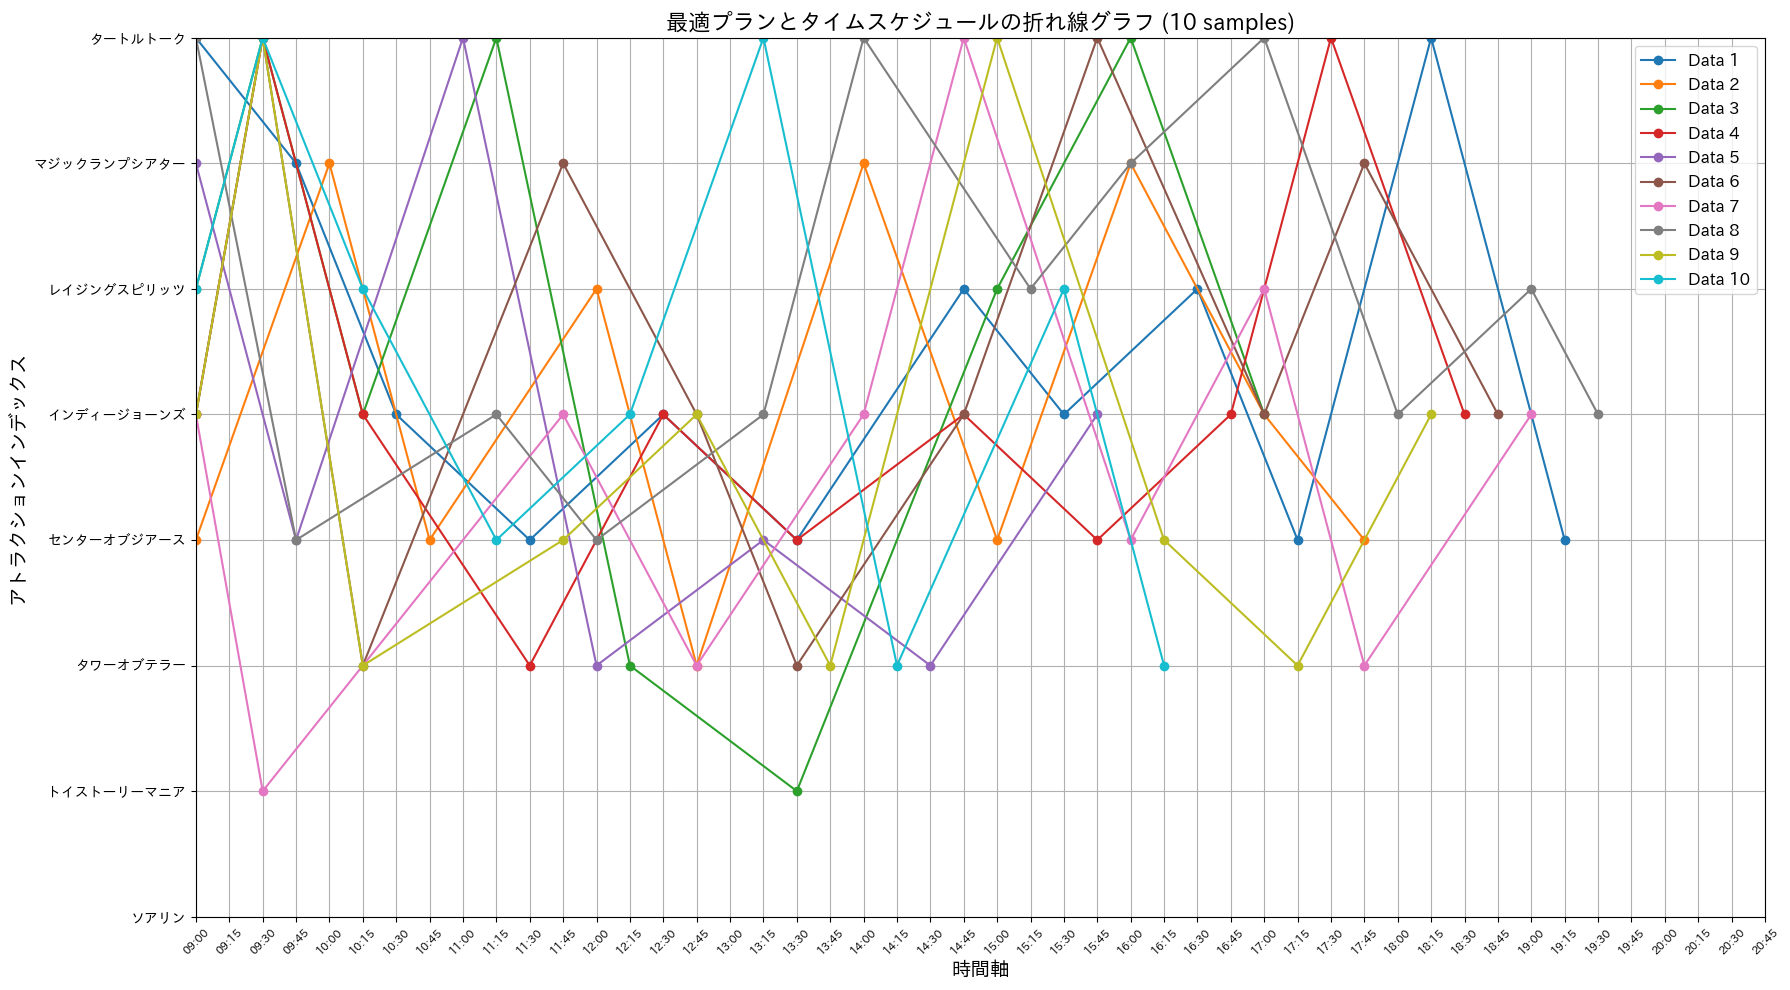

In [123]:
# 関数の呼び出し
plot_time_schedule(df, num_samples=10)

In [124]:
def contains_all_0_to_7(lst):
    # 必要な要素が全て含まれているかをチェックするための基準セット
    required_set = set(range(8))  # {0, 1, 2, 3, 4, 5, 6, 7}
    
    # lst が 0~7 の全てを含むかどうかをチェック
    return required_set.issubset(set(lst))

In [125]:
# '最適プラン' に 0〜7が全て含まれるデータをフィルタリング
df['最適プラン'] = df['最適プラン'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
filtered_df = df[df['最適プラン'].apply(contains_all_0_to_7)]

# フィルタリング結果を確認
display(filtered_df)
display(filtered_df.shape)

,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
77,median,4687.0,662.0,"[5, 3, 4, 7, 6, 6, 0, 0, 7, 2, 5, 5, 1]","[5, 3, 4, 7, 6, 0, 7, 2, 5, 1]","[0, 30, 105, 165, 225, 285, 390, 465, 540, 585]"
97,median,4682.0,661.5,"[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[0, 30, 120, 225, 270, 345, 435, 495, 555, 615]"


(2, 6)

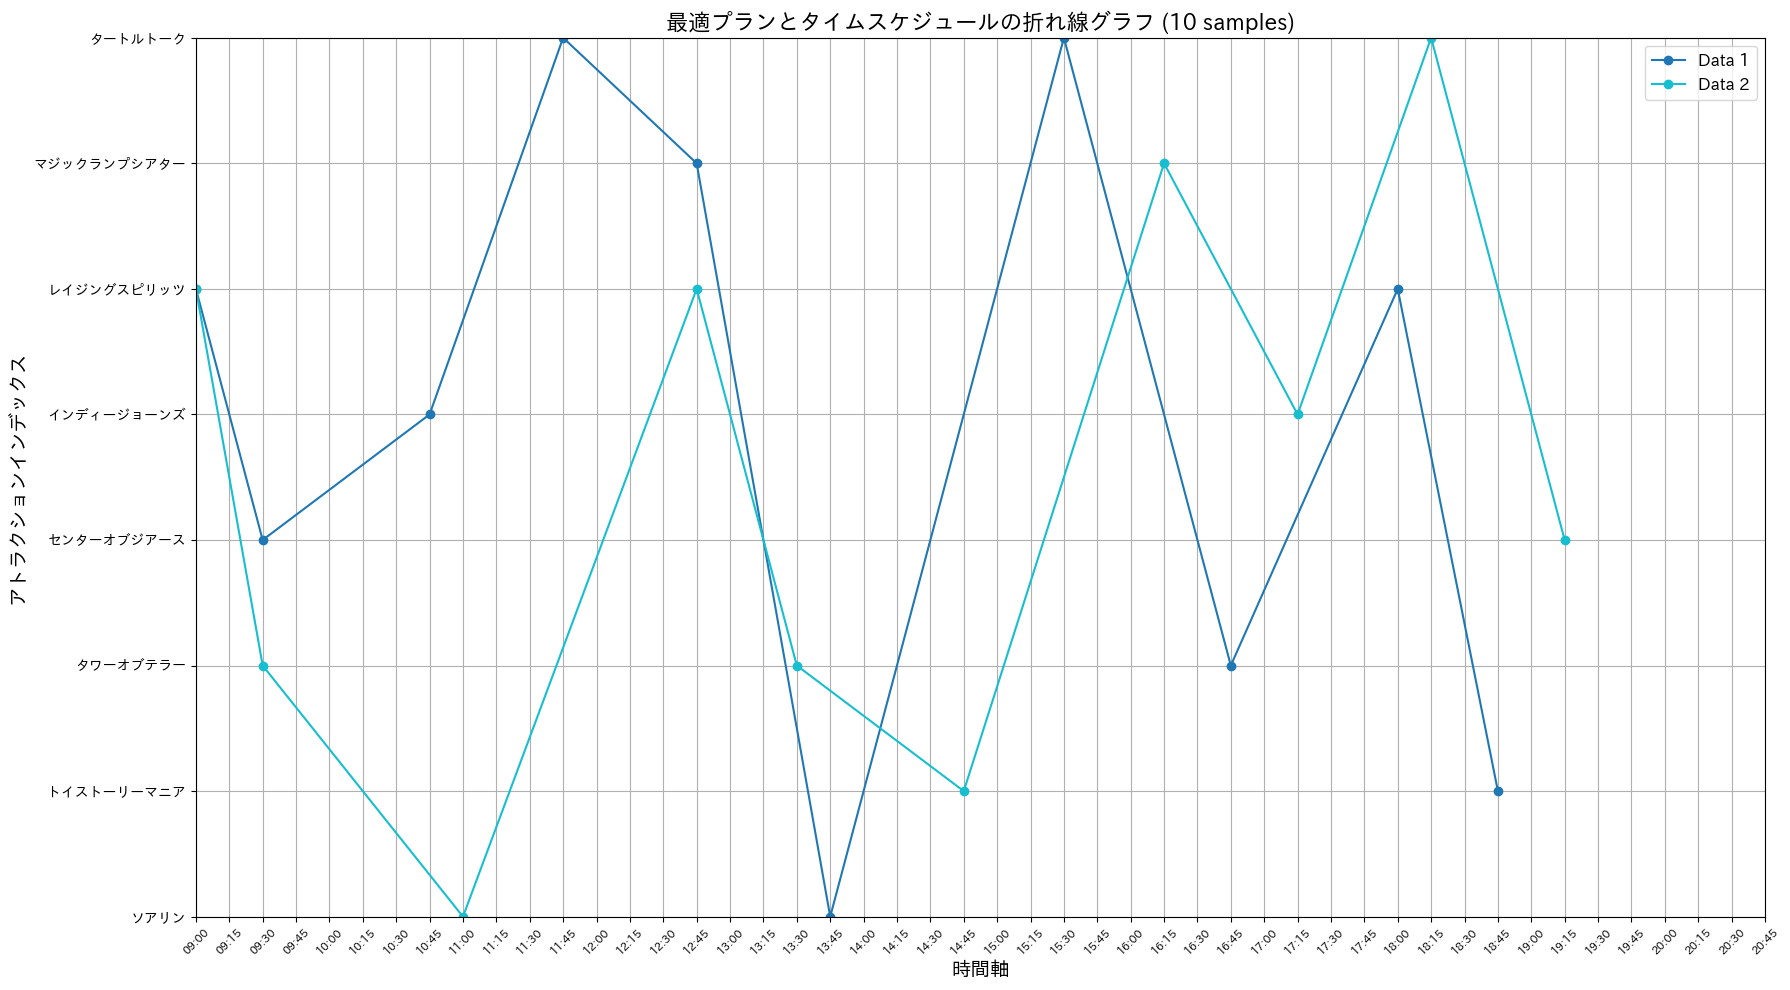

In [126]:
# 関数の呼び出し
plot_time_schedule(filtered_df, num_samples=10)

In [127]:
# 最大トータル満足度のデータ
max_popularity = filtered_df[filtered_df["トータル満足度"] == filtered_df["トータル満足度"].max()]

# 最小トータル所要時間のデータ
min_totaltime = filtered_df[filtered_df["トータル所要時間"] == filtered_df["トータル所要時間"].min()]

display(max_popularity)
display(min_totaltime)

# 各要素を取得1
data1 = max_popularity.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
data1 = [data1[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data1[1:]]
date1 = data1[0]
total_popularity1 = data1[1]
total_time1 = data1[2]
ride_lst1 = data1[3]
new_ride_lst1 = data1[4]
ride_time1 = data1[5]

# 各要素を取得2
data2 = min_totaltime.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
data2 = [data2[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data2[1:]]
date2 = data2[0]
total_popularity2 = data2[1]
total_time2 = data2[2]
ride_lst2 = data2[3]
new_ride_lst2 = data2[4]
ride_time2 = data2[5]

# ride_printerで表示
print("トータル満足度が最大のプラン")
ride_printer(data1, total_popularity1, total_time1, ride_lst1, new_ride_lst1, ride_time1)
print()
#print("トータル所要時間が最小のプラン")
#ride_printer(data2, total_popularity2, total_time2, ride_lst2, new_ride_lst2, ride_time2)
#print()


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
77,median,4687.0,662.0,"[5, 3, 4, 7, 6, 6, 0, 0, 7, 2, 5, 5, 1]","[5, 3, 4, 7, 6, 0, 7, 2, 5, 1]","[0, 30, 105, 165, 225, 285, 390, 465, 540, 585]"


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
97,median,4682.0,661.5,"[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[0, 30, 120, 225, 270, 345, 435, 495, 555, 615]"


トータル満足度が最大のプラン
----------------------------------------
~ ['median', 4687.0, 662.0, [5, 3, 4, 7, 6, 6, 0, 0, 7, 2, 5, 5, 1], [5, 3, 4, 7, 6, 0, 7, 2, 5, 1], [0, 30, 105, 165, 225, 285, 390, 465, 540, 585]] のデータによる乗車プラン ~
乗車時間　：　アトラクション名
09:00　： レイジングスピリッツ
09:30　： センターオブジアース
10:45　： インディージョーンズ
11:45　： タートルトーク
12:45　： マジックランプシアター
13:45　： ソアリン
15:30　： タートルトーク
16:45　： タワーオブテラー
18:00　： レイジングスピリッツ
18:45　： トイストーリーマニア
トータル所要時間： 662.0
トータル満足度　： 4687.0
----------------------------------------
※全てのアトラクションを乗ることができません
プランから除外されたアトラクション
6　： マジックランプシアター
0　： ソアリン
5　： レイジングスピリッツ



In [128]:
sorted_filtered_df = filtered_df.sort_values(by='トータル満足度', ascending=False)

# フィルタリングとソート結果を確認
display(sorted_filtered_df)
display(sorted_filtered_df.shape)


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
77,median,4687.0,662.0,"[5, 3, 4, 7, 6, 6, 0, 0, 7, 2, 5, 5, 1]","[5, 3, 4, 7, 6, 0, 7, 2, 5, 1]","[0, 30, 105, 165, 225, 285, 390, 465, 540, 585]"
97,median,4682.0,661.5,"[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[5, 2, 0, 5, 2, 1, 6, 4, 7, 3]","[0, 30, 120, 225, 270, 345, 435, 495, 555, 615]"


(2, 6)

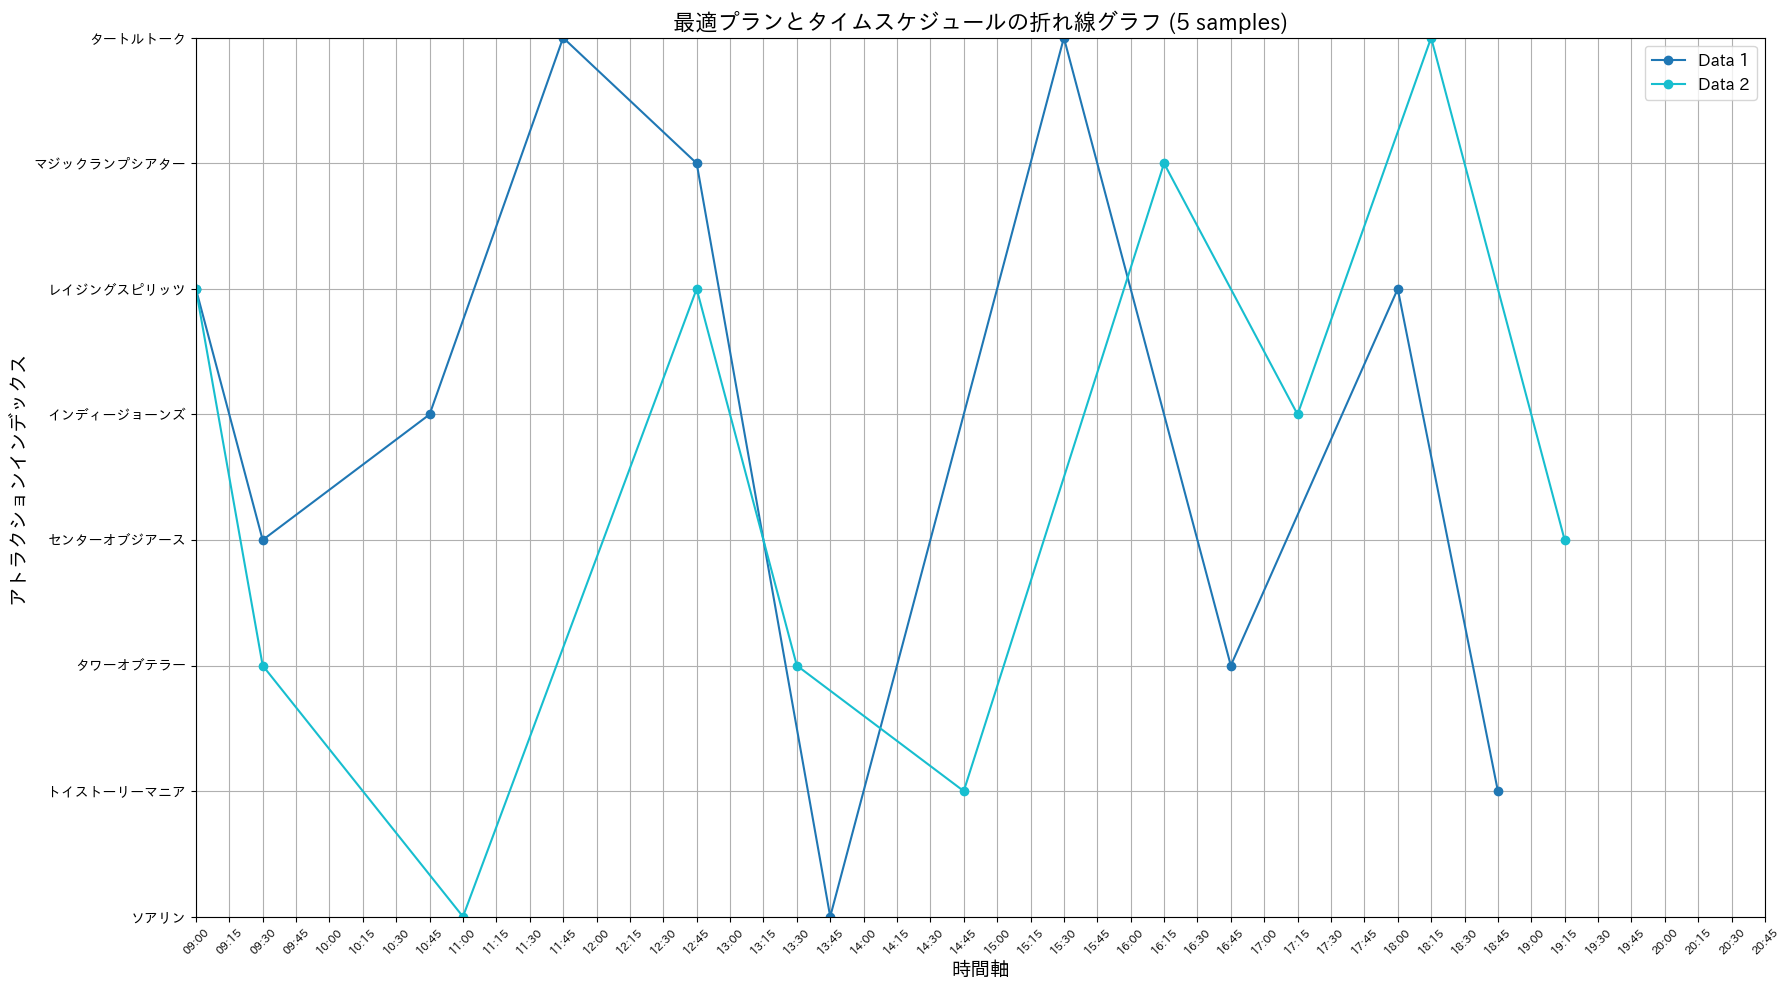

In [132]:
# 関数の呼び出し
plot_time_schedule(sorted_filtered_df, num_samples=5)

In [134]:
sorted_filtered_df.to_csv('bestplan_median_review.csv', index=False)

In [130]:
# 既存のbestplan_dfがリスト型であると仮定します
bestplan_df = []  # 初期化（既にデータがある場合はこの行は不要）

# max_popularityのデータをリスト形式に変換
data1 = max_popularity.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
data1 = [data1[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data1[1:]]

# bestplan_dfをデータフレームに変換
columns = ['日付', 'トータル満足度', 'トータル所要時間', '予定プラン', '最適プラン', 'タイムスケジュール']
bestplan_df = pd.DataFrame(bestplan_df, columns=columns)  # 初期データフレームの作成

# max_popularityとmin_totaltimeのデータをデータフレームに追加
bestplan_df = bestplan_df.append(pd.Series(data1, index=columns), ignore_index=True)

# 追加結果を表示
display(bestplan_df)

,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
0,median,4687.0,662.0,"[5, 3, 4, 7, 6, 6, 0, 0, 7, 2, 5, 5, 1]","[5, 3, 4, 7, 6, 0, 7, 2, 5, 1]","[0, 30, 105, 165, 225, 285, 390, 465, 540, 585]"


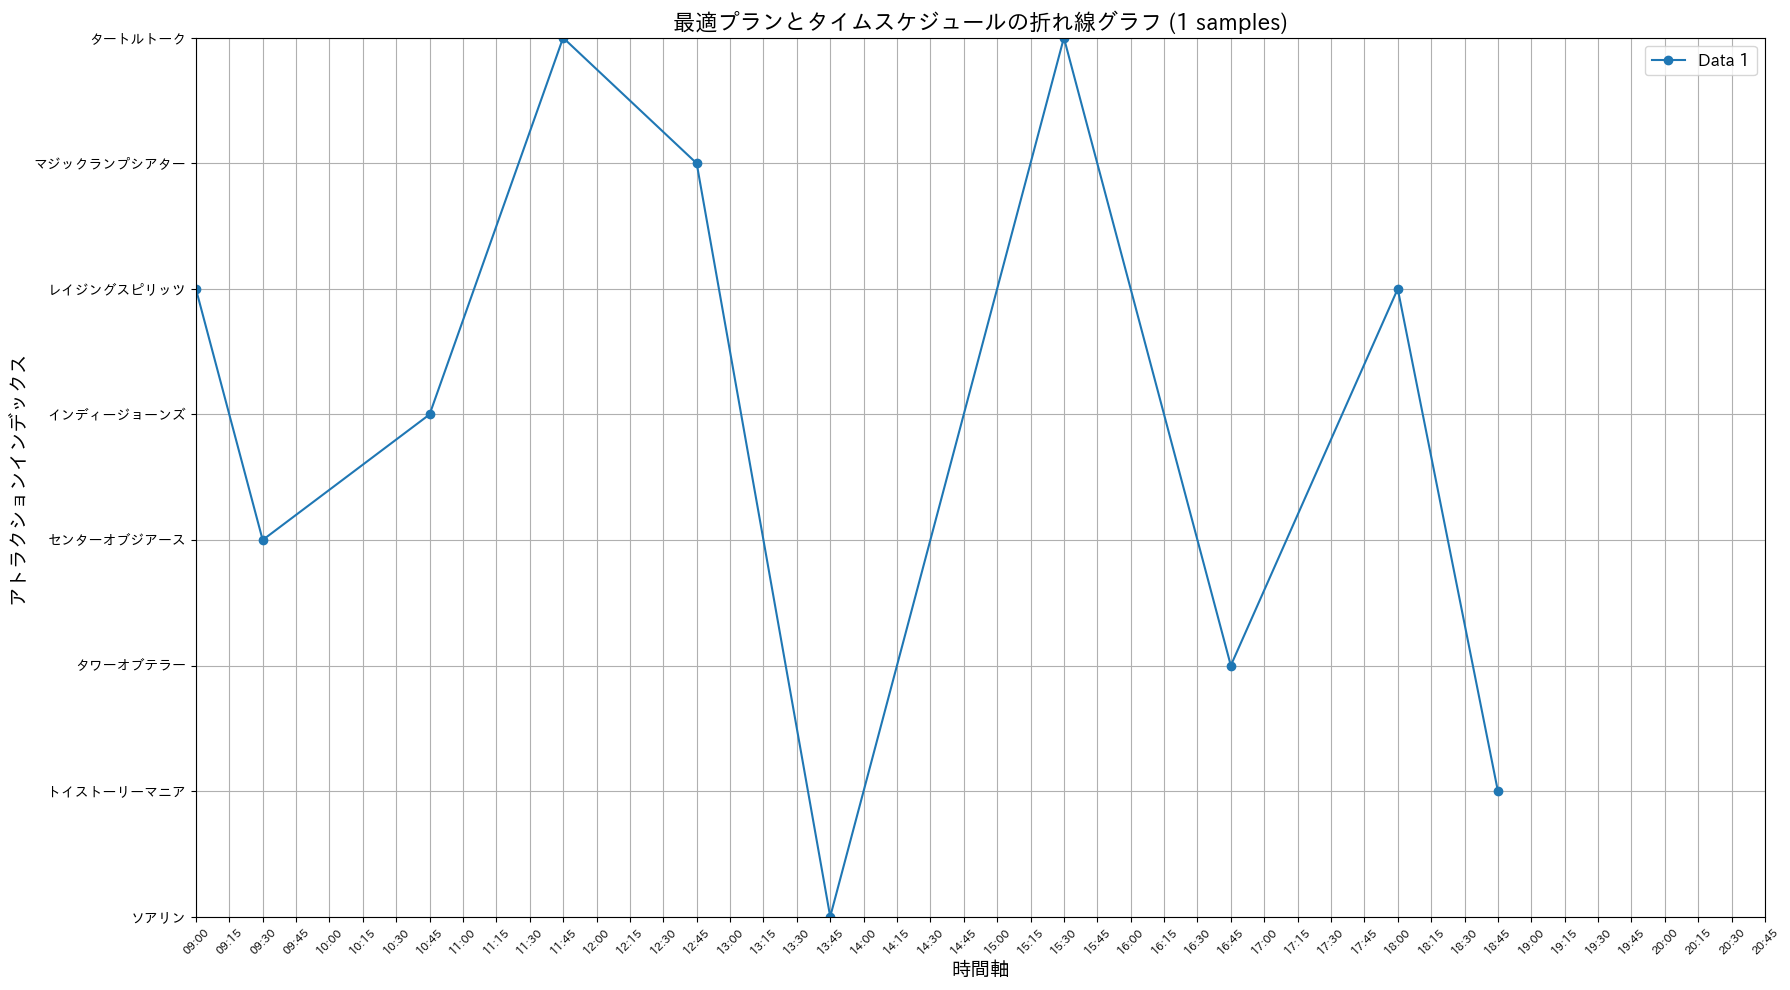

In [131]:
# 関数の呼び出し
plot_time_schedule(bestplan_df, num_samples=1)